<a href="https://colab.research.google.com/github/MrKoh7/movie-app/blob/main/AsainFacesGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Step 1 Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# STEP 2: Creating Workspace Directories for Asian Male
!mkdir -p /content/gan_project_asian_male/train_faces
!mkdir -p /content/gan_project_asian_male/aligned_faces
!mkdir -p /content/gan_project_asian_male/generated_faces

In [ ]:
#Step 3 Install Dependencies
!pip install face_alignment imageio tensorflow==2.15.0 numpy pillow matplotlib

In [ ]:
# STEP 4: Copy Male Images Only from All Separated Datasets
import shutil, os, glob

male_dirs = [
    "/content/drive/MyDrive/separated_dataset1/male",
    "/content/drive/MyDrive/separated_dataset2/male",
    "/content/drive/MyDrive/separated_dataset3/male",
    "/content/drive/MyDrive/separated_dataset4/male",
    "/content/drive/MyDrive/separated_dataset5/male",
    "/content/drive/MyDrive/separated_dataset6/male",
    "/content/drive/MyDrive/separated_dataset7/male",
    "/content/drive/MyDrive/separated_dataset8/male",
]

train_faces_dir = "/content/gan_project_asian_male/train_faces"
for folder in male_dirs:
    for img in glob.glob(folder + "/*"):
        shutil.copy(img, train_faces_dir)

print(f"✅ Copied male images into: {train_faces_dir}")

✅ Copied male images into: /content/gan_project_asian_male/train_faces


🔄 Aligning Asian Male Faces: 100%|██████████| 1776/1776 [04:18<00:00,  6.87it/s]


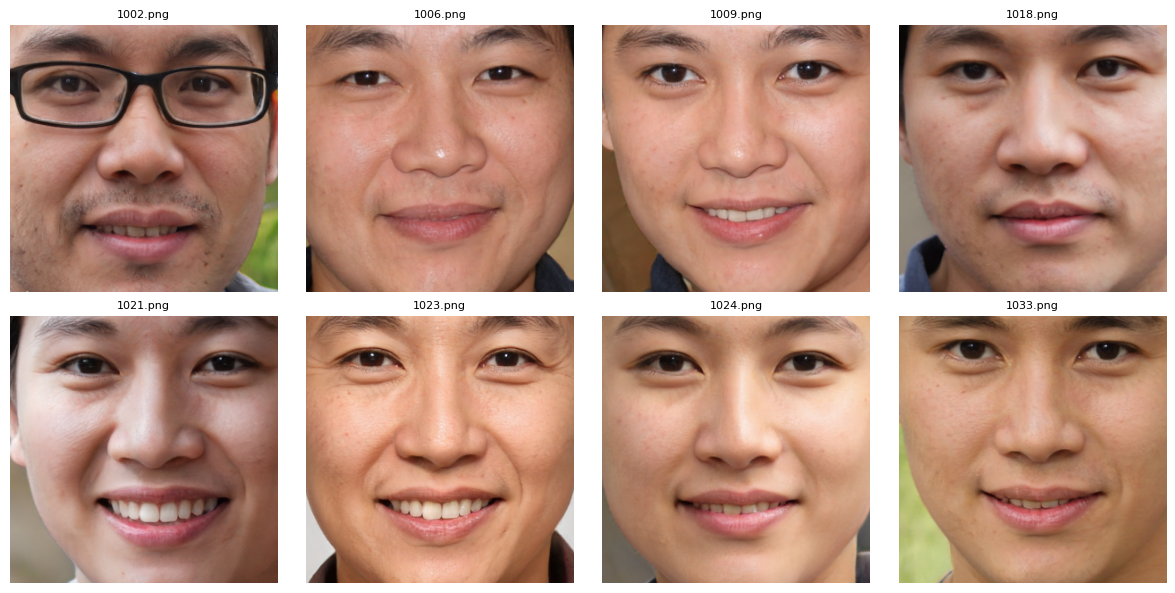

In [ ]:
# Step 5 (Male): Align Asian Male Faces (Eyes Horizontal + Centered)

import face_alignment
from skimage import io
from PIL import Image
import numpy as np
import cv2
import os, glob, shutil, matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize face alignment
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, flip_input=False, device='cuda')

# Paths for Asian Male dataset
input_dir = '/content/gan_project_asian_male/train_faces'
output_dir = '/content/gan_project_asian_male/aligned_faces'
os.makedirs(output_dir, exist_ok=True)

def align_and_crop_face(img_path, output_size=300, zoom_out_factor=4.5):
    try:
        img = io.imread(img_path)
        preds = fa.get_landmarks(img)
        if not preds:
            print(f"❌ No face detected: {img_path}")
            return

        landmarks = preds[0].astype(np.float32)
        left_eye  = landmarks[36]
        right_eye = landmarks[45]
        nose_tip  = landmarks[30]

        dy, dx = right_eye[1] - left_eye[1], right_eye[0] - left_eye[0]
        angle = np.degrees(np.arctan2(dy, dx))
        eye_center = tuple(np.mean([left_eye, right_eye], axis=0).tolist())
        rot_mat = cv2.getRotationMatrix2D(eye_center, angle, 1.0)
        aligned = cv2.warpAffine(img, rot_mat, (img.shape[1], img.shape[0]))

        eye_dist = float(np.linalg.norm(right_eye - left_eye))
        crop_size = int(max(192, min(512, eye_dist * zoom_out_factor)))

        nose = np.array([nose_tip[0], nose_tip[1], 1.0], dtype=np.float32)
        nose_rot = rot_mat @ nose
        cx, cy = int(nose_rot[0]), int(nose_rot[1])

        half = crop_size // 2
        x1, y1 = cx - half, cy - half
        x2, y2 = cx + half, cy + half

        pad_l = max(0, -x1); pad_t = max(0, -y1)
        pad_r = max(0, x2 - aligned.shape[1]); pad_b = max(0, y2 - aligned.shape[0])
        if any([pad_l, pad_t, pad_r, pad_b]):
            aligned = cv2.copyMakeBorder(aligned, pad_t, pad_b, pad_l, pad_r, cv2.BORDER_REFLECT)
            x1 += pad_l; x2 += pad_l; y1 += pad_t; y2 += pad_t

        crop = aligned[y1:y2, x1:x2]
        crop_resized = cv2.resize(crop, (output_size, output_size), interpolation=cv2.INTER_AREA)
        filename = os.path.basename(img_path).rsplit('.', 1)[0] + ".png"
        Image.fromarray(crop_resized).save(os.path.join(output_dir, filename))

    except Exception as e:
        print(f"❌ Error processing {img_path}: {e}")

# Align all male faces
image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
for file in tqdm(image_files, desc="🔄 Aligning Asian Male Faces"):
    align_and_crop_face(os.path.join(input_dir, file))

# Save to Drive
dest_dir = "/content/drive/MyDrive/gan_project_output/aligned_asian_male"
os.makedirs(dest_dir, exist_ok=True)
for p in glob.glob(os.path.join(output_dir, "*")):
    shutil.copy2(p, dest_dir)

# Preview
samples = sorted(glob.glob(os.path.join(dest_dir, "*")))[:8]
if samples:
    plt.figure(figsize=(12, 6))
    for i, fp in enumerate(samples):
        img = Image.open(fp).convert("RGB")
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(os.path.basename(fp)[:18], fontsize=8)
    plt.tight_layout()
else:
    print("⚠️ No images found to preview. Check that alignment ran successfully.")

In [ ]:
# Step 6: Train GAN on Aligned Asian Male Faces
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from glob import glob

TARGET_SIZE = 64
LATENT_DIM   = 100
BATCH_SIZE   = 32
EPOCHS       = 1300
SAVE_FREQ    = 500

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# ---- paths (male) ----
ALIGNED_DIR   = "/content/gan_project_asian_male/aligned_faces"
GEN_OUT_DIR   = "/content/gan_project_asian_male/generated_faces"

def load_images(path):
    images = []
    for file in glob(os.path.join(path, "*.png")):
        try:
            img = Image.open(file).convert("RGB").resize((TARGET_SIZE, TARGET_SIZE))
            img = np.asarray(img, dtype=np.float32) / 127.5 - 1.0  # [-1,1]
            images.append(img)
        except Exception as e:
            print(f"❌ Error loading {file}: {e}")
    return np.array(images)

def build_generator():
    return tf.keras.Sequential([
        layers.Dense(8*8*256, use_bias=False, input_shape=(LATENT_DIM,)),
        layers.BatchNormalization(), layers.LeakyReLU(),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(), layers.LeakyReLU(),
        layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(), layers.LeakyReLU(),
        layers.Conv2DTranspose(3, 5, strides=2, padding='same', use_bias=False, activation='tanh')
    ])

def build_discriminator():
    return tf.keras.Sequential([
        layers.Conv2D(64, 5, strides=2, padding='same', input_shape=(TARGET_SIZE, TARGET_SIZE, 3)),
        layers.LeakyReLU(), layers.Dropout(0.3),
        layers.Conv2D(128, 5, strides=2, padding='same'),
        layers.LeakyReLU(), layers.Dropout(0.3),
        layers.Flatten(), layers.Dense(1)
    ])

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    return (cross_entropy(tf.ones_like(real_output), real_output) +
            cross_entropy(tf.zeros_like(fake_output), fake_output))

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer     = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

images = load_images(ALIGNED_DIR)
print(f"✅ Loaded {images.shape[0]} aligned male faces.")
dataset = (tf.data.Dataset.from_tensor_slices(images)
           .shuffle(1000)
           .batch(BATCH_SIZE)
           .prefetch(tf.data.AUTOTUNE))

generator     = build_generator()
discriminator = build_discriminator()

@tf.function
def train_step(real_images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)
        real_out = discriminator(real_images, training=True)
        fake_out = discriminator(fake_images, training=True)
        g_loss = generator_loss(fake_out)
        d_loss = discriminator_loss(real_out, fake_out)
    generator_optimizer.apply_gradients(
        zip(gen_tape.gradient(g_loss, generator.trainable_variables), generator.trainable_variables))
    discriminator_optimizer.apply_gradients(
        zip(disc_tape.gradient(d_loss, discriminator.trainable_variables), discriminator.trainable_variables))
    return g_loss, d_loss

def generate_images(model, epoch, num=5):
    noise = tf.random.normal([num, LATENT_DIM])
    imgs = model(noise, training=False)
    imgs = tf.cast((imgs + 1.0) * 127.5, tf.uint8).numpy()  # back to [0,255]
    os.makedirs(GEN_OUT_DIR, exist_ok=True)
    for i, img in enumerate(imgs):
        Image.fromarray(img).save(os.path.join(GEN_OUT_DIR, f"epoch{epoch:04d}_img{i}.png"))

for epoch in range(EPOCHS):
    g_loss = d_loss = None
    for real_images in dataset:
        g_loss, d_loss = train_step(real_images)
    if g_loss is not None:
        print(f"Epoch {epoch}, Gen Loss: {g_loss.numpy():.4f}, Disc Loss: {d_loss.numpy():.4f}")
        if epoch % SAVE_FREQ == 0 or epoch == EPOCHS - 1:
            generate_images(generator, epoch)


✅ Loaded 1776 aligned male faces.
Epoch 0, Gen Loss: 2.0805, Disc Loss: 0.3222
Epoch 1, Gen Loss: 3.3787, Disc Loss: 0.0765
Epoch 2, Gen Loss: 4.4299, Disc Loss: 0.1365
Epoch 3, Gen Loss: 3.1929, Disc Loss: 0.2266
Epoch 4, Gen Loss: 3.6921, Disc Loss: 0.1445
Epoch 5, Gen Loss: 3.5845, Disc Loss: 0.0559
Epoch 6, Gen Loss: 6.3923, Disc Loss: 0.0315
Epoch 7, Gen Loss: 5.0995, Disc Loss: 0.0692
Epoch 8, Gen Loss: 3.6880, Disc Loss: 0.1432
Epoch 9, Gen Loss: 6.7824, Disc Loss: 0.5939
Epoch 10, Gen Loss: 5.2125, Disc Loss: 0.2966
Epoch 11, Gen Loss: 3.1081, Disc Loss: 0.3848
Epoch 12, Gen Loss: 2.5388, Disc Loss: 0.6010
Epoch 13, Gen Loss: 1.7018, Disc Loss: 0.4600
Epoch 14, Gen Loss: 1.8718, Disc Loss: 0.7964
Epoch 15, Gen Loss: 1.5519, Disc Loss: 0.4842
Epoch 16, Gen Loss: 1.5226, Disc Loss: 0.5770
Epoch 17, Gen Loss: 1.4983, Disc Loss: 0.5480
Epoch 18, Gen Loss: 1.5881, Disc Loss: 0.5245
Epoch 19, Gen Loss: 1.7582, Disc Loss: 0.7348
Epoch 20, Gen Loss: 1.9368, Disc Loss: 1.0541
Epoch 21, 

In [ ]:
# FINAL SAVE for Generator, Discriminator, and Checkpoint (Asian Male - 1300 Epochs)

import tensorflow as tf
import os

# 1) Ensure checkpoint directory exists
ckpt_dir = "/content/drive/MyDrive/checkpoints_asian_male_full"
os.makedirs(ckpt_dir, exist_ok=True)

# 2) Create a checkpoint object that includes model + optimizers
ckpt = tf.train.Checkpoint(
    generator=generator,
    discriminator=discriminator,
    gen_optimizer=generator_optimizer,
    disc_optimizer=discriminator_optimizer
)

# 3) Save a checkpoint so training can resume exactly from here
ckpt_manager = tf.train.CheckpointManager(
    ckpt,
    ckpt_dir,
    max_to_keep=5
)

save_path = ckpt_manager.save()
print(f"✅ Full training state saved at checkpoint: {save_path}")
print("   You can resume later using this checkpoint without losing optimizer state.")

# 4) Save final generator for backend/inference use
gen_path = "/content/drive/MyDrive/generator_asian_male_final(1300K).h5"
generator.save(gen_path)
print(f"✅ Final generator model saved at: {gen_path}")

# 5) Save discriminator (optional, for evaluation/analysis)
disc_path = "/content/drive/MyDrive/discriminator_asian_male_final(1300K).h5"
discriminator.save(disc_path)
print(f"✅ Final discriminator model saved at: {disc_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Full training state saved at checkpoint: /content/drive/MyDrive/checkpoints_asian_male_full/ckpt-1
   You can resume later using this checkpoint without losing optimizer state.
✅ Final generator model saved at: /content/drive/MyDrive/generator_asian_male_final(1300K).h5
✅ Final discriminator model saved at: /content/drive/MyDrive/discriminator_asian_male_final(1300K).h5


In [ ]:
# Continue training 1300 -> 2000 in the same session (no re-init)
EXTRA_EPOCHS = 700
START_EPOCH  = 1300
SAVE_FREQ    = 200  # save images & checkpoint every 200

# Slight LR decay for refinement
generator_optimizer.learning_rate.assign(5e-5)
discriminator_optimizer.learning_rate.assign(5e-5)

dataset = dataset.prefetch(tf.data.AUTOTUNE)  # keep GPU busy

# If you don't already have this in scope, uncomment this minimal version:
import os
import tensorflow as tf
import numpy as np
from PIL import Image
TARGET_SIZE = 64; LATENT_DIM = 100
GEN_OUT_DIR = "/content/gan_project_asian_male/generated_faces"
def generate_images(model, epoch, num=5):
    noise = tf.random.normal([num, LATENT_DIM])
    imgs = model(noise, training=False)
    imgs = tf.cast((imgs + 1.0) * 127.5, tf.uint8).numpy()
    os.makedirs(GEN_OUT_DIR, exist_ok=True)
    for i, img in enumerate(imgs):
        Image.fromarray(img).save(os.path.join(GEN_OUT_DIR, f"epoch{epoch:04d}_img{i}.png"))

for epoch in range(START_EPOCH, START_EPOCH + EXTRA_EPOCHS):
    g_loss = d_loss = None
    for real_images in dataset:
        g_loss, d_loss = train_step(real_images)

    print(f"Epoch {epoch}, Gen Loss: {g_loss.numpy():.4f}, Disc Loss: {d_loss.numpy():.4f}")

    if epoch % SAVE_FREQ == 0 or epoch == START_EPOCH + EXTRA_EPOCHS - 1:
        # 🔸 save a few sample images like Step 6
        generate_images(generator, epoch, num=5)
        # 🔸 and checkpoint models
        ckpt_manager.save()

# Final saves at ~2000
generator.save("/content/drive/MyDrive/generator_asian_male_final(2000K).h5")
discriminator.save("/content/drive/MyDrive/discriminator_asian_male_final(2000K).h5")
ckpt_manager.save()
print("✅ Reached ~2000 epochs and saved generator/discriminator + checkpoint.")


Epoch 1300, Gen Loss: 1.1104, Disc Loss: 1.2419
Epoch 1301, Gen Loss: 1.1993, Disc Loss: 0.8827
Epoch 1302, Gen Loss: 1.3103, Disc Loss: 1.2297
Epoch 1303, Gen Loss: 1.2030, Disc Loss: 1.0112
Epoch 1304, Gen Loss: 1.0222, Disc Loss: 1.1655
Epoch 1305, Gen Loss: 1.0845, Disc Loss: 1.2844
Epoch 1306, Gen Loss: 1.1306, Disc Loss: 1.0849
Epoch 1307, Gen Loss: 0.9657, Disc Loss: 1.3196
Epoch 1308, Gen Loss: 0.7451, Disc Loss: 1.1919
Epoch 1309, Gen Loss: 0.9888, Disc Loss: 1.2269
Epoch 1310, Gen Loss: 1.3616, Disc Loss: 1.1853
Epoch 1311, Gen Loss: 1.0620, Disc Loss: 1.1786
Epoch 1312, Gen Loss: 1.2759, Disc Loss: 1.2570
Epoch 1313, Gen Loss: 1.0214, Disc Loss: 1.0309
Epoch 1314, Gen Loss: 0.9175, Disc Loss: 1.3479
Epoch 1315, Gen Loss: 1.1172, Disc Loss: 1.0980
Epoch 1316, Gen Loss: 1.2413, Disc Loss: 1.0247
Epoch 1317, Gen Loss: 1.1725, Disc Loss: 0.9558
Epoch 1318, Gen Loss: 1.0955, Disc Loss: 1.0540
Epoch 1319, Gen Loss: 1.1731, Disc Loss: 0.9915
Epoch 1320, Gen Loss: 1.2254, Disc Loss:

Epoch 1999, Gen Loss: 1.4412, Disc Loss: 0.9189
✅ Reached ~2000 epochs and saved generator/discriminator + checkpoint.


In [ ]:
# STEP 7: Save Train + Aligned + Generated (Overwrite Previous for Asian Male)

output_drive_dir = "/content/drive/MyDrive/gan_project_asian_male_output"

# Ensure parent exists
!mkdir -p "$output_drive_dir"

# Remove old copies so we fully overwrite
!rm -rf "$output_drive_dir/train" "$output_drive_dir/aligned" "$output_drive_dir/generated"

# Copy fresh folders
!cp -r /content/gan_project_asian_male/train_faces     "$output_drive_dir/train"
!cp -r /content/gan_project_asian_male/aligned_faces   "$output_drive_dir/aligned"
!cp -r /content/gan_project_asian_male/generated_faces "$output_drive_dir/generated"

print("✅ Saved to Drive → gan_project_asian_male_output/{train, aligned, generated} (overwritten).")


✅ Saved to Drive → gan_project_asian_male_output/{train, aligned, generated} (overwritten).


In [ ]:
# Asian Female
# #Extra epochs result
# # 📸 Re-generate epoch images into /content/generated_faces just like Step 6

# import os, glob
# import numpy as np
# from PIL import Image
# import tensorflow as tf

# # 1) Paths
# checkpoint_dir = "/content/drive/MyDrive/checkpoints"   # where gen_epochXXXX.h5 were saved
# gen_out_dir    = "/content/generated_faces"              # same folder Step 6 used
# os.makedirs(gen_out_dir, exist_ok=True)

# # 2) Fixed noise (so epochs are comparable). 5 images like Step 6.
# LATENT_DIM   = 100
# NUM_SAMPLES  = 5
# FIXED_NOISE  = tf.constant(np.random.normal(0, 1, (NUM_SAMPLES, LATENT_DIM)).astype("float32"))

# # 3) Iterate checkpoints in order
# gen_ckpts = sorted(glob.glob(os.path.join(checkpoint_dir, "gen_epoch*.h5")))
# print(f"🔍 Found {len(gen_ckpts)} generator checkpoints.")

# for ckpt in gen_ckpts:
#     # Extract epoch number (e.g., '0800' from 'gen_epoch0800.h5')
#     epoch_str = os.path.basename(ckpt).replace("gen_epoch", "").replace(".h5", "")
#     epoch_int = int(epoch_str)  # for sanity / sorting if needed

#     # Load generator (no compile to avoid warnings)
#     gen = tf.keras.models.load_model(ckpt, compile=False)

#     # Generate NUM_SAMPLES images with fixed noise
#     imgs = gen(FIXED_NOISE, training=False)
#     imgs = tf.cast((imgs + 1.0) * 127.5, tf.uint8).numpy()  # [-1,1] → [0,255]

#     # Save with Step-6 style filenames: epochXXXX_imgY.png
#     for i, arr in enumerate(imgs):
#         Image.fromarray(arr).save(os.path.join(gen_out_dir, f"epoch{epoch_int:04d}_img{i}.png"))

# print(f"✅ Saved samples for all checkpoints to: {gen_out_dir}")


🔍 Found 12 generator checkpoints.
✅ Saved samples for all checkpoints to: /content/generated_faces


In [ ]:
# Asian Female
# #Extra training from 800 epochs improve model learning
# # ✅ Continue training from current in-memory models (no reinit)

# import numpy as np, os, tensorflow as tf
# from PIL import Image

# # 1) slight LR decay for stability
# generator_optimizer.learning_rate.assign(5e-5)
# discriminator_optimizer.learning_rate.assign(5e-5)

# # 2) (optional) bump batch size if you have headroom
# # BATCH_SIZE = 64  # uncomment if your GPU has room and rebuild dataset

# # 3) make sure pipeline overlaps I/O and compute
# dataset = dataset.prefetch(tf.data.AUTOTUNE)

# # 4) fixed seed so samples are comparable across epochs
# FIXED_NOISE = tf.constant(np.random.normal(0, 1, (16, LATENT_DIM)).astype("float32"))

# def save_fixed_grid(model, epoch):
#     imgs = model(FIXED_NOISE, training=False)
#     imgs = tf.cast((imgs + 1.0) * 127.5, tf.uint8).numpy()  # [-1,1] -> [0,255]
#     os.makedirs("generated_faces", exist_ok=True)
#     # save a 4x4 grid
#     grid = Image.new("RGB", (64*4, 64*4))
#     for i, im in enumerate(imgs[:16]):
#         grid.paste(Image.fromarray(im), box=((i%4)*64, (i//4)*64))
#     grid.save(f"generated_faces/epoch{epoch:04d}_grid.png")

# # 5) continue training
# EXTRA_EPOCHS = 1200         # e.g., go from ~800 -> ~2000
# START_EPOCH  = 800
# SAVE_FREQ    = 100

# for epoch in range(START_EPOCH, START_EPOCH + EXTRA_EPOCHS):
#     g_loss = d_loss = None
#     for real_images in dataset:
#         g_loss, d_loss = train_step(real_images)

#     print(f"Epoch {epoch}, Gen Loss: {g_loss.numpy():.4f}, Disc Loss: {d_loss.numpy():.4f}")

#     if epoch % SAVE_FREQ == 0:
#         save_fixed_grid(generator, epoch)
#         generator.save(f"/content/drive/MyDrive/checkpoints/gen_epoch{epoch:04d}.h5")
#         discriminator.save(f"/content/drive/MyDrive/checkpoints/disc_epoch{epoch:04d}.h5")

# # final save
# generator.save("/content/drive/MyDrive/generator_asian_female.h5")
# print("✅ Continued training done & generator saved.")


Epoch 800, Gen Loss: 1.1275, Disc Loss: 0.7607


Epoch 801, Gen Loss: 0.8243, Disc Loss: 1.5282
Epoch 802, Gen Loss: 1.3478, Disc Loss: 1.2996
Epoch 803, Gen Loss: 0.8594, Disc Loss: 1.4763
Epoch 804, Gen Loss: 0.8240, Disc Loss: 1.4717
Epoch 805, Gen Loss: 1.0583, Disc Loss: 0.9500
Epoch 806, Gen Loss: 0.8299, Disc Loss: 1.9589
Epoch 807, Gen Loss: 1.2228, Disc Loss: 1.1656
Epoch 808, Gen Loss: 1.0950, Disc Loss: 0.9854
Epoch 809, Gen Loss: 1.2655, Disc Loss: 0.7866
Epoch 810, Gen Loss: 0.9756, Disc Loss: 1.1780
Epoch 811, Gen Loss: 1.1667, Disc Loss: 1.1123
Epoch 812, Gen Loss: 0.9599, Disc Loss: 1.4587
Epoch 813, Gen Loss: 1.1843, Disc Loss: 1.1325
Epoch 814, Gen Loss: 0.8566, Disc Loss: 1.5641
Epoch 815, Gen Loss: 1.2736, Disc Loss: 1.0907
Epoch 816, Gen Loss: 0.7587, Disc Loss: 1.3480
Epoch 817, Gen Loss: 0.8202, Disc Loss: 1.2256
Epoch 818, Gen Loss: 1.2739, Disc Loss: 1.3939
Epoch 819, Gen Loss: 1.0855, Disc Loss: 0.8893
Epoch 820, Gen Loss: 0.8573, Disc Loss: 1.4324
Epoch 821, Gen Loss: 1.4643, Disc Loss: 0.7656
Epoch 822, Ge

Epoch 900, Gen Loss: 0.6824, Disc Loss: 1.5904
Epoch 901, Gen Loss: 1.1398, Disc Loss: 0.6718
Epoch 902, Gen Loss: 0.8404, Disc Loss: 1.6843
Epoch 903, Gen Loss: 1.2073, Disc Loss: 0.9097
Epoch 904, Gen Loss: 0.7616, Disc Loss: 1.8774
Epoch 905, Gen Loss: 1.3982, Disc Loss: 0.6734
Epoch 906, Gen Loss: 0.7732, Disc Loss: 1.5904
Epoch 907, Gen Loss: 1.4259, Disc Loss: 0.9317
Epoch 908, Gen Loss: 0.6313, Disc Loss: 1.3961
Epoch 909, Gen Loss: 0.9474, Disc Loss: 1.1201
Epoch 910, Gen Loss: 0.5692, Disc Loss: 1.4258
Epoch 911, Gen Loss: 0.8725, Disc Loss: 1.1065
Epoch 912, Gen Loss: 0.7560, Disc Loss: 1.2811
Epoch 913, Gen Loss: 1.2743, Disc Loss: 0.9684
Epoch 914, Gen Loss: 0.7365, Disc Loss: 1.9695
Epoch 915, Gen Loss: 1.6359, Disc Loss: 0.9182
Epoch 916, Gen Loss: 1.0098, Disc Loss: 1.1563
Epoch 917, Gen Loss: 1.1951, Disc Loss: 0.9170
Epoch 918, Gen Loss: 0.6934, Disc Loss: 1.6989
Epoch 919, Gen Loss: 1.1567, Disc Loss: 1.0282
Epoch 920, Gen Loss: 0.8204, Disc Loss: 1.2006
Epoch 921, Ge

Epoch 1000, Gen Loss: 0.9352, Disc Loss: 1.4027
Epoch 1001, Gen Loss: 0.9623, Disc Loss: 1.2970
Epoch 1002, Gen Loss: 1.0953, Disc Loss: 1.1194
Epoch 1003, Gen Loss: 0.6892, Disc Loss: 1.4967
Epoch 1004, Gen Loss: 1.1799, Disc Loss: 0.9746
Epoch 1005, Gen Loss: 0.8889, Disc Loss: 1.7516
Epoch 1006, Gen Loss: 1.0567, Disc Loss: 1.1537
Epoch 1007, Gen Loss: 1.0322, Disc Loss: 1.1195
Epoch 1008, Gen Loss: 1.0384, Disc Loss: 1.1468
Epoch 1009, Gen Loss: 1.1155, Disc Loss: 0.8983
Epoch 1010, Gen Loss: 0.9231, Disc Loss: 1.1366
Epoch 1011, Gen Loss: 0.8815, Disc Loss: 0.9715
Epoch 1012, Gen Loss: 1.3164, Disc Loss: 0.9290
Epoch 1013, Gen Loss: 0.7841, Disc Loss: 1.4531
Epoch 1014, Gen Loss: 1.0142, Disc Loss: 0.8955
Epoch 1015, Gen Loss: 0.9711, Disc Loss: 1.3568
Epoch 1016, Gen Loss: 0.6484, Disc Loss: 1.3303
Epoch 1017, Gen Loss: 0.8794, Disc Loss: 1.4031
Epoch 1018, Gen Loss: 0.6163, Disc Loss: 1.5983
Epoch 1019, Gen Loss: 1.0914, Disc Loss: 1.1524
Epoch 1020, Gen Loss: 1.0312, Disc Loss:

Epoch 1100, Gen Loss: 1.3472, Disc Loss: 0.6018
Epoch 1101, Gen Loss: 0.7114, Disc Loss: 1.4317
Epoch 1102, Gen Loss: 1.2381, Disc Loss: 1.0609
Epoch 1103, Gen Loss: 0.7463, Disc Loss: 1.8290
Epoch 1104, Gen Loss: 1.0411, Disc Loss: 0.9917
Epoch 1105, Gen Loss: 0.8183, Disc Loss: 1.4756
Epoch 1106, Gen Loss: 0.9568, Disc Loss: 1.3592
Epoch 1107, Gen Loss: 0.8475, Disc Loss: 1.1849
Epoch 1108, Gen Loss: 0.6988, Disc Loss: 1.8293
Epoch 1109, Gen Loss: 1.6685, Disc Loss: 0.7244
Epoch 1110, Gen Loss: 0.8449, Disc Loss: 1.8846
Epoch 1111, Gen Loss: 1.0149, Disc Loss: 1.2579
Epoch 1112, Gen Loss: 0.6395, Disc Loss: 1.6221
Epoch 1113, Gen Loss: 1.1059, Disc Loss: 0.9426
Epoch 1114, Gen Loss: 0.8884, Disc Loss: 1.3281
Epoch 1115, Gen Loss: 0.9900, Disc Loss: 1.2454
Epoch 1116, Gen Loss: 0.9536, Disc Loss: 0.9523
Epoch 1117, Gen Loss: 0.5804, Disc Loss: 1.7494
Epoch 1118, Gen Loss: 1.3203, Disc Loss: 0.9032
Epoch 1119, Gen Loss: 0.7050, Disc Loss: 1.4283
Epoch 1120, Gen Loss: 1.0787, Disc Loss:

Epoch 1200, Gen Loss: 1.2383, Disc Loss: 0.9127
Epoch 1201, Gen Loss: 0.8174, Disc Loss: 0.9649
Epoch 1202, Gen Loss: 1.1558, Disc Loss: 1.2229
Epoch 1203, Gen Loss: 0.8942, Disc Loss: 1.6981
Epoch 1204, Gen Loss: 0.7896, Disc Loss: 1.1233
Epoch 1205, Gen Loss: 0.9286, Disc Loss: 1.1974
Epoch 1206, Gen Loss: 0.8431, Disc Loss: 1.5074
Epoch 1207, Gen Loss: 1.4157, Disc Loss: 0.9633
Epoch 1208, Gen Loss: 0.6315, Disc Loss: 1.3796
Epoch 1209, Gen Loss: 1.2615, Disc Loss: 1.2658
Epoch 1210, Gen Loss: 0.8399, Disc Loss: 1.2530
Epoch 1211, Gen Loss: 0.8608, Disc Loss: 1.2767
Epoch 1212, Gen Loss: 1.1185, Disc Loss: 1.1670
Epoch 1213, Gen Loss: 0.6857, Disc Loss: 1.2780
Epoch 1214, Gen Loss: 1.2166, Disc Loss: 1.2626
Epoch 1215, Gen Loss: 0.5615, Disc Loss: 1.7020
Epoch 1216, Gen Loss: 1.1586, Disc Loss: 0.8882
Epoch 1217, Gen Loss: 0.7674, Disc Loss: 1.4664
Epoch 1218, Gen Loss: 1.1022, Disc Loss: 1.2336
Epoch 1219, Gen Loss: 0.8712, Disc Loss: 1.2549
Epoch 1220, Gen Loss: 0.9611, Disc Loss:

Epoch 1300, Gen Loss: 0.8705, Disc Loss: 1.0091
Epoch 1301, Gen Loss: 0.8530, Disc Loss: 1.4807
Epoch 1302, Gen Loss: 0.9439, Disc Loss: 1.2988
Epoch 1303, Gen Loss: 1.0190, Disc Loss: 1.0694
Epoch 1304, Gen Loss: 1.1509, Disc Loss: 1.2148
Epoch 1305, Gen Loss: 1.0080, Disc Loss: 1.2326
Epoch 1306, Gen Loss: 1.0261, Disc Loss: 1.3738
Epoch 1307, Gen Loss: 1.0105, Disc Loss: 1.1156
Epoch 1308, Gen Loss: 1.2350, Disc Loss: 0.8948
Epoch 1309, Gen Loss: 0.7848, Disc Loss: 1.4762
Epoch 1310, Gen Loss: 1.0200, Disc Loss: 1.0416
Epoch 1311, Gen Loss: 0.8048, Disc Loss: 1.4226
Epoch 1312, Gen Loss: 1.1248, Disc Loss: 0.8942
Epoch 1313, Gen Loss: 0.7706, Disc Loss: 1.2515
Epoch 1314, Gen Loss: 1.2199, Disc Loss: 0.9425
Epoch 1315, Gen Loss: 0.7236, Disc Loss: 1.6524
Epoch 1316, Gen Loss: 1.0275, Disc Loss: 0.9847
Epoch 1317, Gen Loss: 0.8131, Disc Loss: 1.3006
Epoch 1318, Gen Loss: 0.7944, Disc Loss: 1.2103
Epoch 1319, Gen Loss: 0.8044, Disc Loss: 1.7834
Epoch 1320, Gen Loss: 1.0457, Disc Loss:

Epoch 1400, Gen Loss: 0.9472, Disc Loss: 1.2992
Epoch 1401, Gen Loss: 1.0368, Disc Loss: 1.0404
Epoch 1402, Gen Loss: 0.6909, Disc Loss: 1.2274
Epoch 1403, Gen Loss: 0.9722, Disc Loss: 1.2815
Epoch 1404, Gen Loss: 0.8428, Disc Loss: 1.3262
Epoch 1405, Gen Loss: 0.8526, Disc Loss: 1.4713
Epoch 1406, Gen Loss: 0.9801, Disc Loss: 1.2274
Epoch 1407, Gen Loss: 1.1325, Disc Loss: 1.1697
Epoch 1408, Gen Loss: 1.0685, Disc Loss: 1.3096
Epoch 1409, Gen Loss: 1.0155, Disc Loss: 1.2235
Epoch 1410, Gen Loss: 0.9129, Disc Loss: 1.2586
Epoch 1411, Gen Loss: 1.1452, Disc Loss: 0.9612
Epoch 1412, Gen Loss: 0.6786, Disc Loss: 1.6167
Epoch 1413, Gen Loss: 1.1148, Disc Loss: 0.8428
Epoch 1414, Gen Loss: 0.7910, Disc Loss: 1.6914
Epoch 1415, Gen Loss: 1.1543, Disc Loss: 0.8254
Epoch 1416, Gen Loss: 0.7121, Disc Loss: 1.5311
Epoch 1417, Gen Loss: 1.2056, Disc Loss: 0.8638
Epoch 1418, Gen Loss: 0.8619, Disc Loss: 1.3347
Epoch 1419, Gen Loss: 1.0531, Disc Loss: 1.2080
Epoch 1420, Gen Loss: 1.0839, Disc Loss:

Epoch 1500, Gen Loss: 0.7432, Disc Loss: 1.4125
Epoch 1501, Gen Loss: 1.2436, Disc Loss: 1.3674
Epoch 1502, Gen Loss: 0.5098, Disc Loss: 1.8613
Epoch 1503, Gen Loss: 1.4917, Disc Loss: 1.0589
Epoch 1504, Gen Loss: 0.6598, Disc Loss: 1.2783
Epoch 1505, Gen Loss: 0.8917, Disc Loss: 1.5272
Epoch 1506, Gen Loss: 0.8628, Disc Loss: 1.1551
Epoch 1507, Gen Loss: 1.0640, Disc Loss: 0.8462
Epoch 1508, Gen Loss: 0.8687, Disc Loss: 1.4450
Epoch 1509, Gen Loss: 1.0599, Disc Loss: 0.9954
Epoch 1510, Gen Loss: 0.7965, Disc Loss: 1.2367
Epoch 1511, Gen Loss: 0.5969, Disc Loss: 1.9513
Epoch 1512, Gen Loss: 1.1921, Disc Loss: 1.0037
Epoch 1513, Gen Loss: 0.7062, Disc Loss: 1.3118
Epoch 1514, Gen Loss: 0.9536, Disc Loss: 1.4156
Epoch 1515, Gen Loss: 1.1256, Disc Loss: 0.8517
Epoch 1516, Gen Loss: 0.8723, Disc Loss: 1.6184
Epoch 1517, Gen Loss: 1.1146, Disc Loss: 0.9019
Epoch 1518, Gen Loss: 0.7055, Disc Loss: 1.4218
Epoch 1519, Gen Loss: 1.3102, Disc Loss: 0.6198
Epoch 1520, Gen Loss: 0.7535, Disc Loss:

Epoch 1600, Gen Loss: 0.9223, Disc Loss: 1.1318
Epoch 1601, Gen Loss: 1.1579, Disc Loss: 0.9774
Epoch 1602, Gen Loss: 1.0441, Disc Loss: 1.1063
Epoch 1603, Gen Loss: 0.8016, Disc Loss: 1.6837
Epoch 1604, Gen Loss: 1.1370, Disc Loss: 0.7554
Epoch 1605, Gen Loss: 0.7095, Disc Loss: 1.7973
Epoch 1606, Gen Loss: 1.0813, Disc Loss: 0.9201
Epoch 1607, Gen Loss: 0.8083, Disc Loss: 1.5571
Epoch 1608, Gen Loss: 1.2518, Disc Loss: 1.0297
Epoch 1609, Gen Loss: 0.9183, Disc Loss: 1.1853
Epoch 1610, Gen Loss: 0.8844, Disc Loss: 1.4895
Epoch 1611, Gen Loss: 1.4264, Disc Loss: 0.9339
Epoch 1612, Gen Loss: 0.5666, Disc Loss: 1.3449
Epoch 1613, Gen Loss: 1.1519, Disc Loss: 0.8063
Epoch 1614, Gen Loss: 0.7408, Disc Loss: 1.5904
Epoch 1615, Gen Loss: 1.1730, Disc Loss: 0.8035
Epoch 1616, Gen Loss: 0.6507, Disc Loss: 1.5841
Epoch 1617, Gen Loss: 1.1204, Disc Loss: 1.0804
Epoch 1618, Gen Loss: 0.9737, Disc Loss: 1.1793
Epoch 1619, Gen Loss: 0.8994, Disc Loss: 1.4533
Epoch 1620, Gen Loss: 1.0378, Disc Loss:

Epoch 1700, Gen Loss: 0.6344, Disc Loss: 1.4852
Epoch 1701, Gen Loss: 1.0854, Disc Loss: 1.0658
Epoch 1702, Gen Loss: 0.8620, Disc Loss: 1.1358
Epoch 1703, Gen Loss: 0.8399, Disc Loss: 1.3625
Epoch 1704, Gen Loss: 1.0244, Disc Loss: 1.0197
Epoch 1705, Gen Loss: 0.7684, Disc Loss: 1.4825
Epoch 1706, Gen Loss: 1.0704, Disc Loss: 1.0388
Epoch 1707, Gen Loss: 1.0862, Disc Loss: 1.0733
Epoch 1708, Gen Loss: 0.8070, Disc Loss: 1.4448
Epoch 1709, Gen Loss: 1.0471, Disc Loss: 1.0922
Epoch 1710, Gen Loss: 1.4917, Disc Loss: 0.7126
Epoch 1711, Gen Loss: 0.9191, Disc Loss: 1.4901
Epoch 1712, Gen Loss: 0.8201, Disc Loss: 1.3173
Epoch 1713, Gen Loss: 1.1608, Disc Loss: 1.1342
Epoch 1714, Gen Loss: 1.2131, Disc Loss: 0.9415
Epoch 1715, Gen Loss: 0.7671, Disc Loss: 1.3066
Epoch 1716, Gen Loss: 0.8727, Disc Loss: 1.2709
Epoch 1717, Gen Loss: 0.9462, Disc Loss: 0.9896
Epoch 1718, Gen Loss: 0.7825, Disc Loss: 1.2630
Epoch 1719, Gen Loss: 0.8526, Disc Loss: 1.3273
Epoch 1720, Gen Loss: 1.1776, Disc Loss:

Epoch 1800, Gen Loss: 1.3902, Disc Loss: 0.6995
Epoch 1801, Gen Loss: 0.7358, Disc Loss: 1.6802
Epoch 1802, Gen Loss: 0.8599, Disc Loss: 1.1909
Epoch 1803, Gen Loss: 1.4090, Disc Loss: 0.6421
Epoch 1804, Gen Loss: 0.5322, Disc Loss: 1.8248
Epoch 1805, Gen Loss: 1.0676, Disc Loss: 0.9092
Epoch 1806, Gen Loss: 0.6489, Disc Loss: 1.7458
Epoch 1807, Gen Loss: 1.0551, Disc Loss: 0.9343
Epoch 1808, Gen Loss: 1.2475, Disc Loss: 0.9271
Epoch 1809, Gen Loss: 0.5996, Disc Loss: 1.4870
Epoch 1810, Gen Loss: 1.6154, Disc Loss: 0.8787
Epoch 1811, Gen Loss: 0.9098, Disc Loss: 1.6995
Epoch 1812, Gen Loss: 1.3257, Disc Loss: 0.8290
Epoch 1813, Gen Loss: 0.8419, Disc Loss: 1.8201
Epoch 1814, Gen Loss: 1.1737, Disc Loss: 0.9041
Epoch 1815, Gen Loss: 0.7149, Disc Loss: 1.4057
Epoch 1816, Gen Loss: 0.8345, Disc Loss: 1.7150
Epoch 1817, Gen Loss: 1.3561, Disc Loss: 0.7369
Epoch 1818, Gen Loss: 0.5267, Disc Loss: 1.6625
Epoch 1819, Gen Loss: 1.2857, Disc Loss: 1.0056
Epoch 1820, Gen Loss: 0.9743, Disc Loss:

Epoch 1900, Gen Loss: 0.8070, Disc Loss: 1.2742
Epoch 1901, Gen Loss: 1.0851, Disc Loss: 0.9597
Epoch 1902, Gen Loss: 0.8707, Disc Loss: 1.2446
Epoch 1903, Gen Loss: 0.6990, Disc Loss: 1.5909
Epoch 1904, Gen Loss: 1.0843, Disc Loss: 1.2246
Epoch 1905, Gen Loss: 1.1690, Disc Loss: 1.0872
Epoch 1906, Gen Loss: 0.7836, Disc Loss: 1.7979
Epoch 1907, Gen Loss: 1.0831, Disc Loss: 1.1291
Epoch 1908, Gen Loss: 0.9136, Disc Loss: 1.5200
Epoch 1909, Gen Loss: 0.9669, Disc Loss: 1.0503
Epoch 1910, Gen Loss: 0.9163, Disc Loss: 1.3305
Epoch 1911, Gen Loss: 1.0402, Disc Loss: 0.9077
Epoch 1912, Gen Loss: 0.7448, Disc Loss: 1.7353
Epoch 1913, Gen Loss: 1.3621, Disc Loss: 0.7413
Epoch 1914, Gen Loss: 0.8656, Disc Loss: 1.1903
Epoch 1915, Gen Loss: 1.0124, Disc Loss: 1.2130
Epoch 1916, Gen Loss: 0.8835, Disc Loss: 1.0917
Epoch 1917, Gen Loss: 1.2938, Disc Loss: 1.0261
Epoch 1918, Gen Loss: 1.3375, Disc Loss: 0.8831
Epoch 1919, Gen Loss: 0.6307, Disc Loss: 1.6757
Epoch 1920, Gen Loss: 1.1354, Disc Loss:

Epoch 1999, Gen Loss: 0.9229, Disc Loss: 1.4305
✅ Continued training done & generator saved.


In [ ]:
# Asian Female
# #Save Generator Asian Female
# # ✅ Final save after extra training

# import tensorflow as tf

# # 1) Save full training state (for resuming later)
# ckpt = tf.train.Checkpoint(
#     generator=generator,
#     discriminator=discriminator,
#     gen_optimizer=generator_optimizer,
#     disc_optimizer=discriminator_optimizer
# )

# ckpt_manager = tf.train.CheckpointManager(
#     ckpt,
#     "/content/drive/MyDrive/checkpoints_full",  # folder for full training state
#     max_to_keep=5  # keep last 5 checkpoints
# )

# save_path = ckpt_manager.save()
# print(f"✅ Full training state saved at: {save_path}")

# # 2) Save final generator only (for backend use/inference)
# generator.save("/content/drive/MyDrive/generator_asian_female_final2K.h5")
# print("✅ Final generator model saved separately for inference.")

# # 3) Optional: Save discriminator if needed for later analysis
# discriminator.save("/content/drive/MyDrive/discriminator_asian_female2K_final.h5")
# print("✅ Final discriminator model saved.")

✅ Full training state saved at: /content/drive/MyDrive/checkpoints_full/ckpt-1
✅ Final generator model saved separately for inference.
✅ Final discriminator model saved.
